## Heal Sight Prediction

### Project Overview
The project is a predictive healthcare capacity managemnet initiative by HealSight.
 
Objectives:
- Predict Patient addmissions
- Optimize bed and ward allocation
- Reduce emergency overflow incidents

Data Integration:

- Combined 3 years of historical admission, discharge, and staffing data.
- Clean and structure datasets for modeling.

Predictive Modeling:

- Build a time-series model predicting 7-day, 14-day, and 30-day patient inflows.
- Applly regression analysis to forecast bed demand per ward.


### Load Datasets

In [1]:
# Load the Libraries

# Install required packages if missing
#%pip install matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # type: ignore

In [2]:
# Import the csv files as dataframes

df_addmissions = pd.read_csv(r"C:\Users\Etteba\OneDrive\Documents\DataSciencePortfolioProjects\HealSightPrediction\Amdari-HealSight-Prediction\Datasets\admissions.csv")
df_dailymetrics = pd.read_csv(r"C:\Users\Etteba\OneDrive\Documents\DataSciencePortfolioProjects\HealSightPrediction\Amdari-HealSight-Prediction\Datasets\daily_metrics.csv")
df_hospitals = pd.read_csv(r"C:\Users\Etteba\OneDrive\Documents\DataSciencePortfolioProjects\HealSightPrediction\Amdari-HealSight-Prediction\Datasets\hospitals.csv")
df_wards = pd.read_csv(r"C:\Users\Etteba\OneDrive\Documents\DataSciencePortfolioProjects\HealSightPrediction\Amdari-HealSight-Prediction\Datasets\wards.csv")

In [3]:
# We will look at the object types and shape for the DataFrames

print("Admissions type:", type(df_addmissions))
print("Admissions shape:", df_addmissions.shape)
print()
print("Daily Metrics type:", type(df_dailymetrics ))
print("Daily Metrics shape:", df_dailymetrics .shape)
print()
print("Hospital type:", type(df_hospitals))
print("Hospital shape:", df_hospitals.shape)
print()
print("Ward type:", type(df_wards))
print("Ward shape:", df_wards.shape)

Admissions type: <class 'pandas.core.frame.DataFrame'>
Admissions shape: (18510, 12)

Daily Metrics type: <class 'pandas.core.frame.DataFrame'>
Daily Metrics shape: (17690, 14)

Hospital type: <class 'pandas.core.frame.DataFrame'>
Hospital shape: (5, 7)

Ward type: <class 'pandas.core.frame.DataFrame'>
Ward shape: (20, 5)


##  Step 1. Data Cleaning


#### a. Clean Admissions DataFrame

In [4]:
# Lets start cleaning by looking at an overview of the admissions dataframe
print(df_addmissions.head())


df_addmissions.tail()

   admission_id        date  hospital_id ward_code arrival_source  \
0             1  2022-10-28            1        ED       referral   
1             2  2022-10-28            1        ED      ambulance   
2             3  2022-10-28            1        ED           self   
3             4  2022-10-28            1        ED           self   
4             5  2022-10-28            1        ED           self   

   triage_level  wait_minutes  length_of_stay_days      outcome   age sex  \
0           4.0           189                  0.0   discharged  48.0   M   
1           4.0           189                  0.0  transferred  93.0   F   
2           2.0           189                  0.0   discharged  52.0   M   
3           3.0           189                  0.0   discharged  64.0   M   
4           4.0           189                  0.0   discharged  59.0   M   

   procedure_flag  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  


,admission_id,date,hospital_id,ward_code,arrival_source,triage_level,wait_minutes,length_of_stay_days,outcome,age,sex,procedure_flag
18505,18506,2024-10-21,1,ICU,ambulance,NaN,131,4.0,discharged,52.0,F,0.0
18506,18507,2024-10-21,1,ICU,self,NaN,131,4.0,discharged,36.0,F,0.0
18507,18508,2024-10-21,1,ICU,referral,NaN,131,9.0,discharged,85.0,F,0.0
18508,18509,2024-10-21,1,ICU,ambulance,NaN,131,15.0,discharged,76.0,M,0.0
18509,18510,2024-10-21,1,ICU,self,NaN,131,NaN,NaN,NaN,NaN,NaN


In [5]:
# We will inpect the dataframes one after the otherfor cleaning purposes
df_addmissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18510 entries, 0 to 18509
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   admission_id         18510 non-null  int64  
 1   date                 18510 non-null  object 
 2   hospital_id          18510 non-null  int64  
 3   ward_code            18510 non-null  object 
 4   arrival_source       18510 non-null  object 
 5   triage_level         13140 non-null  float64
 6   wait_minutes         18510 non-null  int64  
 7   length_of_stay_days  18509 non-null  float64
 8   outcome              18509 non-null  object 
 9   age                  18509 non-null  float64
 10  sex                  18509 non-null  object 
 11  procedure_flag       18509 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 1.7+ MB


- The information from results above indicates a clean dataframe but there is some cleaning to done here.
1. Handle Data types - Convert to apprpriate data types
  * Change the date colummn to datetime
  * Convert ward_code , arrival_source, outcome and sex columns to category
  * Convert age, procedure_flag to int64
  * length_of_stay_days has 1 missing value (fill with median or drop)
  * triage_level has to be investigated for missing values also set dtype to int64.


##### Convert columns to approproiate datatype except triage_level column

In [6]:
# Convert columns excluding the triage_level column for now
df_addmissions['date'] = pd.to_datetime(df_addmissions['date'], errors='coerce')
df_addmissions['ward_code'] = df_addmissions['ward_code'].astype('category')
df_addmissions['arrival_source'] = df_addmissions['arrival_source'].astype('category')
df_addmissions['outcome'] = df_addmissions['outcome'].astype('category')
df_addmissions['sex'] = df_addmissions['sex'].astype('category')
df_addmissions['hospital_id'] = df_addmissions['hospital_id'].astype('category')

# Age and procedure_flag as integers

df_addmissions['age'] = df_addmissions['age'].round().astype('Int64')
df_addmissions['procedure_flag'] = df_addmissions['procedure_flag'].astype('Int64')




##### Treat Missing Values

In [ ]:
# We will replace the missing values in the numerical columns with their median values
df_addmissions['length_of_stay_days'].fillna(df_addmissions['length_of_stay_days'].median(), inplace=True) 
df_addmissions['age'].fillna(df_addmissions['age'].median(), inplace=True)
df_addmissions['procedure_flag'].fillna(df_addmissions['procedure_flag'].median(), inplace=True)

In [ ]:
# We will treat the categorical columns by replacing missing values with the mode
df_addmissions['outcome'].fillna(df_addmissions['outcome'].mode()[0], inplace=True)
df_addmissions['sex'].fillna(df_addmissions['sex'].mode()[0], inplace=True)

#### Triage Level column
-  The triage_level  had about 29% of its value missing . We will treat this column now.

In [9]:
# Checking for unique values in the triage_level column
df_addmissions['triage_level'].unique()

array([ 4.,  2.,  3.,  5.,  1., nan])

- Seems there are 5 categories in this variable. A good case to covert the dtype to category.

In [10]:
# To safely handle the missing values in the triage_level column,so we dont loose the records avoid bias and for the model to still learn from the missing values,  we will convert it to category data type

df_addmissions['triage_level'] = df_addmissions['triage_level'].astype('Int64').astype('object')

# Since this is an ML project we will replace the missing values with 'Unknown'
df_addmissions['triage_level'] = df_addmissions['triage_level'].fillna('Unknown')

# Finally convert the triage_level column to category data type
df_addmissions['triage_level'] = df_addmissions['triage_level'].astype('category')



In [11]:
df_addmissions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18510 entries, 0 to 18509
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   admission_id         18510 non-null  int64         
 1   date                 18510 non-null  datetime64[ns]
 2   hospital_id          18510 non-null  category      
 3   ward_code            18510 non-null  category      
 4   arrival_source       18510 non-null  category      
 5   triage_level         18510 non-null  category      
 6   wait_minutes         18510 non-null  int64         
 7   length_of_stay_days  18510 non-null  float64       
 8   outcome              18510 non-null  category      
 9   age                  18510 non-null  Int64         
 10  sex                  18510 non-null  category      
 11  procedure_flag       18510 non-null  Int64         
dtypes: Int64(2), category(6), datetime64[ns](1), float64(1), int64(2)
memory usage: 1013.3 K

#### b. Clean Daily Metrics DataFrame

In [12]:
print(df_dailymetrics.head())
df_dailymetrics.tail()

         date  hospital_id ward_code  base_beds  effective_capacity  \
0  2022-10-28          1.0        ED       30.0                34.0   
1  2022-10-29          1.0        ED       30.0                34.0   
2  2022-10-30          1.0        ED       30.0                34.0   
3  2022-10-31          1.0        ED       30.0                34.0   
4  2022-11-01          1.0        ED       30.0                34.0   

   occupancy  overflow  admissions  discharges  staffing_index  \
0       34.0      26.0        51.0        17.0           0.999   
1       34.0      35.0        62.0        31.0           0.938   
2       34.0      39.0        63.0        28.0           0.953   
3       34.0      26.0        56.0        34.0           0.974   
4       34.0      29.0        55.0        30.0           1.013   

   avg_wait_minutes  admission_rate_per_bed  discharge_rate_per_bed  \
0             219.0                   1.700                   0.567   
1             223.0               

,date,hospital_id,ward_code,base_beds,effective_capacity,occupancy,overflow,admissions,discharges,staffing_index,avg_wait_minutes,admission_rate_per_bed,discharge_rate_per_bed,occupancy_rate
17685,2023-04-11,5.0,ED,30.0,34.0,34.0,39.0,68.0,33.0,1.002,298.0,2.267,1.100,1.0
17686,2023-04-12,5.0,ED,30.0,34.0,34.0,34.0,63.0,33.0,1.016,179.0,2.100,1.100,1.0
17687,2023-04-13,5.0,ED,30.0,34.0,34.0,44.0,71.0,31.0,1.045,308.0,2.367,1.033,1.0
17688,2023-04-14,5.0,ED,30.0,34.0,34.0,34.0,62.0,32.0,0.998,230.0,2.067,1.067,1.0
17689,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_dailymetrics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    17690 non-null  object 
 1   hospital_id             17689 non-null  float64
 2   ward_code               17689 non-null  object 
 3   base_beds               17689 non-null  float64
 4   effective_capacity      17689 non-null  float64
 5   occupancy               17689 non-null  float64
 6   overflow                17689 non-null  float64
 7   admissions              17689 non-null  float64
 8   discharges              17689 non-null  float64
 9   staffing_index          17689 non-null  float64
 10  avg_wait_minutes        17689 non-null  float64
 11  admission_rate_per_bed  17689 non-null  float64
 12  discharge_rate_per_bed  17689 non-null  float64
 13  occupancy_rate          17689 non-null  float64
dtypes: float64(12), object(2)
memory usage

#### The result above tells me that there are 17690 rows with 17689 rows with non null entries. The offending row has to be dropped as the only entry is on the date column which has a non date value(20).
The task here is to:
* Drop the last row with NaN's
* convert date column to datetime column 
* convert hospital_id to category (useful for ML)
* concert base_beds, overflow and addmission to int

In [14]:
# drop the last row with NaN's in Daily metrics dataframe
df_dailymetrics = df_dailymetrics[:-1] if df_dailymetrics.iloc[-1].isna().any() else df_dailymetrics



In [15]:
# Convert date column to datetime
df_dailymetrics['date'] = pd.to_datetime(df_dailymetrics['date'], errors='coerce')

##### Convert columns to numeric and category dtypes

In [16]:
# numerical columns to int
df_dailymetrics['base_beds'] = df_dailymetrics['base_beds'].astype('Int64') 
df_dailymetrics['overflow'] = df_dailymetrics['overflow'].astype('Int64')
df_dailymetrics['admissions'] = df_dailymetrics['admissions'].astype('Int64')
df_dailymetrics['hospital_id'] = df_dailymetrics['hospital_id'].astype('Int64')

In [17]:
# Category column
df_dailymetrics['hospital_id'] = df_dailymetrics['hospital_id'].astype('category') # Converted this column to category as there are 5 unique hospital ids only
df_dailymetrics['ward_code'] = df_dailymetrics['ward_code'].astype('category')

In [18]:
df_dailymetrics.head()

,date,hospital_id,ward_code,base_beds,effective_capacity,occupancy,overflow,admissions,discharges,staffing_index,avg_wait_minutes,admission_rate_per_bed,discharge_rate_per_bed,occupancy_rate
0,2022-10-28,1,ED,30,34.0,34.0,26,51,17.0,0.999,219.0,1.700,0.567,1.0
1,2022-10-29,1,ED,30,34.0,34.0,35,62,31.0,0.938,223.0,2.067,1.033,1.0
2,2022-10-30,1,ED,30,34.0,34.0,39,63,28.0,0.953,275.0,2.100,0.933,1.0
3,2022-10-31,1,ED,30,34.0,34.0,26,56,34.0,0.974,227.0,1.867,1.133,1.0
4,2022-11-01,1,ED,30,34.0,34.0,29,55,30.0,1.013,257.0,1.833,1.000,1.0


In [19]:
df_dailymetrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17689 entries, 0 to 17688
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    17689 non-null  datetime64[ns]
 1   hospital_id             17689 non-null  category      
 2   ward_code               17689 non-null  category      
 3   base_beds               17689 non-null  Int64         
 4   effective_capacity      17689 non-null  float64       
 5   occupancy               17689 non-null  float64       
 6   overflow                17689 non-null  Int64         
 7   admissions              17689 non-null  Int64         
 8   discharges              17689 non-null  float64       
 9   staffing_index          17689 non-null  float64       
 10  avg_wait_minutes        17689 non-null  float64       
 11  admission_rate_per_bed  17689 non-null  float64       
 12  discharge_rate_per_bed  17689 non-null  float6

#### c. Clean Hospitals DataFrame

In [20]:
# Check the dataframe to unde4rstand its structure
print(df_hospitals.head())
print("\n", df_hospitals.shape)
print("\n", df_hospitals.info())

   hospital_id              hospital_name      city  country  latitude  \
0            1  Helsinki Central Hospital  Helsinki  Finland   63.6698   
1            2      Tampere City Hospital   Tampere  Finland   63.2868   
2            3  Turku University Hospital     Turku  Finland   64.6781   
3            4     Oulu Regional Hospital      Oulu  Finland   60.4406   
4            5      Kuopio Medical Center    Kuopio  Finland   61.6540   

   longitude  founded_year  
0    25.0721          1979  
1    22.6592          2008  
2    27.3280          1998  
3    25.1527          2003  
4    28.4874          2003  

 (5, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hospital_id    5 non-null      int64  
 1   hospital_name  5 non-null      object 
 2   city           5 non-null      object 
 3   country        5 non-null      object 
 4   lat

Fairly clean dataframe
 - convert hospital_id to category and
 -  hospital_name, city and country to category 

In [21]:
# convert hospital_id to num and category dtypes
df_hospitals['hospital_id'] = df_hospitals['hospital_id'].astype('Int64').astype('category')
df_hospitals['hospital_name'] = df_hospitals['hospital_name'].astype('category')
df_hospitals['city'] = df_hospitals['city'].astype('category')
df_hospitals['country'] = df_hospitals['country'].astype('category')

In [22]:
df_hospitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   hospital_id    5 non-null      category
 1   hospital_name  5 non-null      category
 2   city           5 non-null      category
 3   country        5 non-null      category
 4   latitude       5 non-null      float64 
 5   longitude      5 non-null      float64 
 6   founded_year   5 non-null      int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 1.0 KB


#### d. Wards DataFrame

In [23]:
# Check the wards dataframe to understand its structure
print(df_wards.head())
df_wards.tail()
print(df_wards.info())


   hospital_id  ward_id ward_code             ward_name  base_beds
0            1    01-ED        ED  Emergency Department         30
1            1   01-ICU       ICU   Intensive Care Unit         20
2            1   01-MED       MED      General Medicine         50
3            1  01-SURG      SURG               Surgery         40
4            2    02-ED        ED  Emergency Department         30
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   hospital_id  20 non-null     int64 
 1   ward_id      20 non-null     object
 2   ward_code    20 non-null     object
 3   ward_name    20 non-null     object
 4   base_beds    20 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 932.0+ bytes
None


- Convert hospital_id , ward_id, ward_code and ward_name to category

In [24]:
# Convert columns to category
df_wards['hospital_id'] = df_wards['hospital_id'].astype('category')    
df_wards['ward_id'] = df_wards['ward_id'].astype('category')
df_wards['ward_code'] = df_wards['ward_code'].astype('category')    
df_wards['ward_name'] = df_wards['ward_name'].astype('category')


In [25]:
df_wards.info() 
print("\n Wards DataFrame Preview:")
print(df_wards.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   hospital_id  20 non-null     category
 1   ward_id      20 non-null     category
 2   ward_code    20 non-null     category
 3   ward_name    20 non-null     category
 4   base_beds    20 non-null     int64   
dtypes: category(4), int64(1)
memory usage: 1.7 KB

 Wards DataFrame Preview:
  hospital_id  ward_id ward_code             ward_name  base_beds
0           1    01-ED        ED  Emergency Department         30
1           1   01-ICU       ICU   Intensive Care Unit         20
2           1   01-MED       MED      General Medicine         50
3           1  01-SURG      SURG               Surgery         40
4           2    02-ED        ED  Emergency Department         30


### Step 2. Merge the DataFrames

In [26]:
# A quick look at the columns in each of these dataFrames
print("Admissions DataFrame Columns:", df_addmissions.columns.tolist())
print("\n Daily Metrics DataFrame Columns:", df_dailymetrics.columns.tolist()) 
print("\n Hospitals DataFrame Columns:", df_hospitals .columns.tolist())
print("\n Wards DataFrame Columns:", df_wards .columns.tolist())

Admissions DataFrame Columns: ['admission_id', 'date', 'hospital_id', 'ward_code', 'arrival_source', 'triage_level', 'wait_minutes', 'length_of_stay_days', 'outcome', 'age', 'sex', 'procedure_flag']

 Daily Metrics DataFrame Columns: ['date', 'hospital_id', 'ward_code', 'base_beds', 'effective_capacity', 'occupancy', 'overflow', 'admissions', 'discharges', 'staffing_index', 'avg_wait_minutes', 'admission_rate_per_bed', 'discharge_rate_per_bed', 'occupancy_rate']

 Hospitals DataFrame Columns: ['hospital_id', 'hospital_name', 'city', 'country', 'latitude', 'longitude', 'founded_year']

 Wards DataFrame Columns: ['hospital_id', 'ward_id', 'ward_code', 'ward_name', 'base_beds']


There are common columns in these Dataframes. Thus, We can merge the DataFrames based on common columns.
Merging of the DataFrames would be done logically starting with:
-  df_admission and df_dailymetrics share the keys ['hospital_id', 'ward_code', 'date']
-  merge the result with df_hospital['hospital_id']
-  finally merge the result with df_wards['hospital_id','ward_code']


In [27]:
# We might want to write a function to automate the merging process


def safe_merge(df_left, df_right, on, suffix_right, how='left'):
    """
    Safely merges two DataFrames.
    - Keeps all rows from the left.
    - Handles overlapping columns by filling left nulls from right.
    - Applies custom suffix for right columns.
    """
    df = df_left.merge(df_right, on=on, how=how, suffixes=('', suffix_right))

    # Find overlapping columns (those that exist with suffix)
    overlap_cols = [c.replace(suffix_right, '') for c in df.columns if c.endswith(suffix_right)]

    for col in overlap_cols:
        col_right = f"{col}{suffix_right}"
        if col in df.columns and col_right in df.columns:
            # Fill missing left values with right values, then drop right col
            df[col] = df[col].fillna(df[col_right])
            df.drop(columns=[col_right], inplace=True)

    return df


In [28]:
# Use the function to merge the DataFrames step by step
merged_addmit_dailymet = safe_merge(
    df_addmissions, df_dailymetrics,
    on=['hospital_id', 'ward_code', 'date'],
    suffix_right='_ward'
)
merged_hospital = safe_merge(
    merged_addmit_dailymet, df_hospitals,
    on=['hospital_id'],
    suffix_right='_hospital'
)
final_merged_healSight_df = safe_merge(
    merged_hospital, df_wards,
    on=['hospital_id', 'ward_code'],        
    suffix_right='_wardinfo'
)   


In [29]:
final_merged_healSight_df.shape


(18510, 31)

In [30]:
final_merged_healSight_df.head()

,admission_id,date,hospital_id,ward_code,arrival_source,triage_level,wait_minutes,length_of_stay_days,outcome,age,...,discharge_rate_per_bed,occupancy_rate,hospital_name,city,country,latitude,longitude,founded_year,ward_id,ward_name
0,1,2022-10-28,1,ED,referral,4,189,0.0,discharged,48,...,0.567,1.0,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-ED,Emergency Department
1,2,2022-10-28,1,ED,ambulance,4,189,0.0,transferred,93,...,0.567,1.0,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-ED,Emergency Department
2,3,2022-10-28,1,ED,self,2,189,0.0,discharged,52,...,0.567,1.0,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-ED,Emergency Department
3,4,2022-10-28,1,ED,self,3,189,0.0,discharged,64,...,0.567,1.0,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-ED,Emergency Department
4,5,2022-10-28,1,ED,self,4,189,0.0,discharged,59,...,0.567,1.0,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-ED,Emergency Department


In [31]:
final_merged_healSight_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18510 entries, 0 to 18509
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   admission_id            18510 non-null  int64         
 1   date                    18510 non-null  datetime64[ns]
 2   hospital_id             18510 non-null  object        
 3   ward_code               18510 non-null  object        
 4   arrival_source          18510 non-null  category      
 5   triage_level            18510 non-null  category      
 6   wait_minutes            18510 non-null  int64         
 7   length_of_stay_days     18510 non-null  float64       
 8   outcome                 18510 non-null  category      
 9   age                     18510 non-null  Int64         
 10  sex                     18510 non-null  category      
 11  procedure_flag          18510 non-null  Int64         
 12  base_beds               18510 non-null  Int64 

In [32]:
# Summary of the final merged DataFrame

print("\nFinal column count:", len(final_merged_healSight_df.columns))
print("\nColumn names:")
print(final_merged_healSight_df.columns.tolist())

print("\nDuplicate Values:")
print(final_merged_healSight_df.duplicated().sum())

print("\nMissing value summary (top 10):")
print(final_merged_healSight_df.isna().sum().sort_values(ascending=False).head(10))

print("\nSample data:")
final_merged_healSight_df.head()


Final column count: 31

Column names:
['admission_id', 'date', 'hospital_id', 'ward_code', 'arrival_source', 'triage_level', 'wait_minutes', 'length_of_stay_days', 'outcome', 'age', 'sex', 'procedure_flag', 'base_beds', 'effective_capacity', 'occupancy', 'overflow', 'admissions', 'discharges', 'staffing_index', 'avg_wait_minutes', 'admission_rate_per_bed', 'discharge_rate_per_bed', 'occupancy_rate', 'hospital_name', 'city', 'country', 'latitude', 'longitude', 'founded_year', 'ward_id', 'ward_name']

Duplicate Values:
0

Missing value summary (top 10):
admission_id           0
date                   0
hospital_id            0
ward_code              0
arrival_source         0
triage_level           0
wait_minutes           0
length_of_stay_days    0
outcome                0
age                    0
dtype: int64

Sample data:


,admission_id,date,hospital_id,ward_code,arrival_source,triage_level,wait_minutes,length_of_stay_days,outcome,age,...,discharge_rate_per_bed,occupancy_rate,hospital_name,city,country,latitude,longitude,founded_year,ward_id,ward_name
0,1,2022-10-28,1,ED,referral,4,189,0.0,discharged,48,...,0.567,1.0,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-ED,Emergency Department
1,2,2022-10-28,1,ED,ambulance,4,189,0.0,transferred,93,...,0.567,1.0,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-ED,Emergency Department
2,3,2022-10-28,1,ED,self,2,189,0.0,discharged,52,...,0.567,1.0,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-ED,Emergency Department
3,4,2022-10-28,1,ED,self,3,189,0.0,discharged,64,...,0.567,1.0,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-ED,Emergency Department
4,5,2022-10-28,1,ED,self,4,189,0.0,discharged,59,...,0.567,1.0,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-ED,Emergency Department


In [33]:
# Save the cleaned and merged DataFrame to a new CSV file
final_merged_healSight_df.to_csv(r"C:\Users\Etteba\OneDrive\Documents\DataSciencePortfolioProjects\HealSightPrediction\Amdari-HealSight-Prediction\Datasets\final_merged_healSight_df.csv", index=False)    

## Step 2. Exploratory Data Analysis

One of the requirements of the project is that we should be able to
1. Build a time-series model predicting 7-day, 14-day, and 30-day patient inflows.
2. Applly regression analysis to forecast bed demand per ward.

Hence to achive this we would involve the following steps:

- Explore the variable to forecast/Temporal structure( Univariate Time series EDA)
- Ward Level Exploration( For Regression)
- Relationships (Correlation) 
- Data Quality checks


In [34]:
# Sort date column
final_merged_healSight_df = final_merged_healSight_df.sort_values(by='date').reset_index(drop=True)

In [ ]:
# Aggregate daily addmissions per day

'''
Since we are  running a time series model, we are looking to have two columns here where one column is the  target variable(admissions)
and the other the predictor variable(date) we would ensure that the data is sorted by date to maintain temporal order.
i.e we want the time stamp to be our index (in this case the column, 'date' serves as a datetime index).
'''

daily_inflow =final_merged_healSight_df.groupby('date', as_index=False)['admissions'].sum()
daily_inflow.head()

,date,admissions
0,2022-10-28,716
1,2022-10-29,840
2,2022-10-30,836
3,2022-10-31,776
4,2022-11-01,748


We can move further by looking deeper to see if there are outliers in our dataFrame.

Text(0.5, 1.0, 'Boxplot of Daily Admissions')

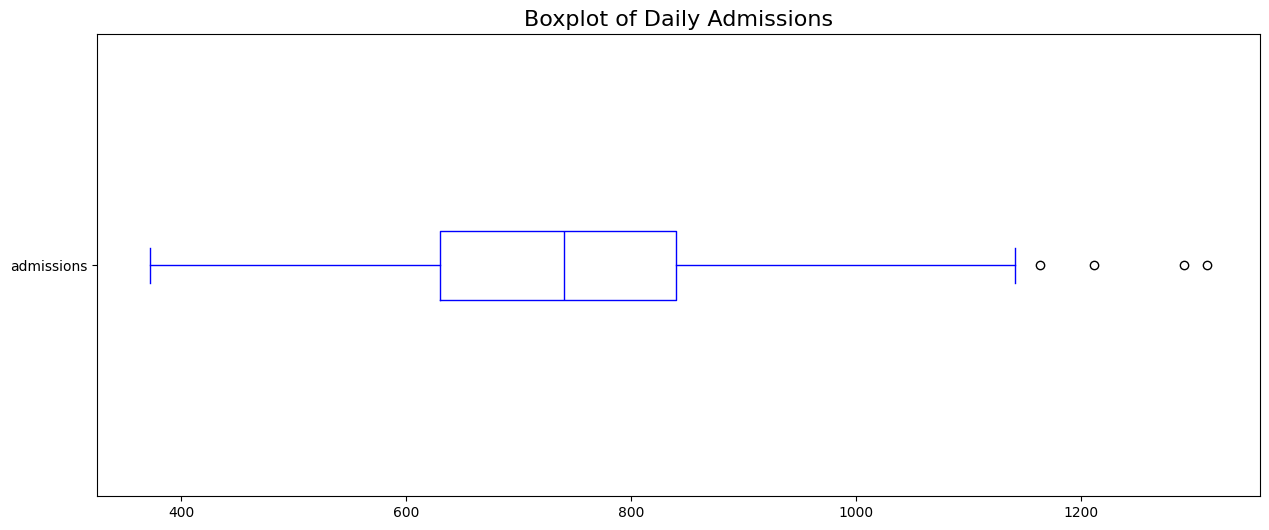

In [47]:
# Using boxplots to look for outliers in the daily inflow dataFrame

# Matplotlib version
fig, ax = plt.subplots(figsize=(15, 6))
daily_inflow["admissions"].plot.box(ax=ax, vert=False, color='blue')
ax.set_title('Boxplot of Daily Admissions', fontsize=16)

The boxplot shows:
- An approximate median reading of ~ 750 addmissions/day
- some outlier readings that we cannot class as extreme for the following reasons that they are not very far off the max value on our scale(1200) and the World Health organisation does not have a specified value or threshold for daily inflows. Thus we would work with the data as is.

Create a line Plot

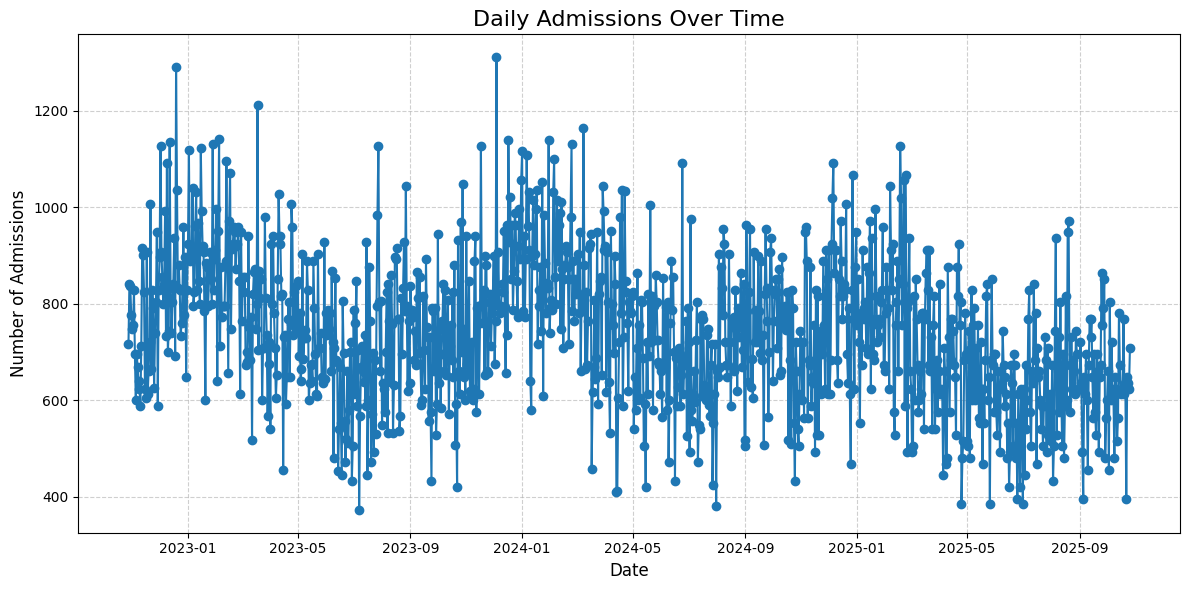

In [ ]:
# Plot daily admissions over time

# fig, ax = plt.subplots(figsize=(15, 6))
# ax.plot(daily_inflow['date'], daily_inflow['admissions'], color='lightblue')
# ax.set_title('Daily Admissions Over Time', fontsize=16)

plt.figure(figsize=(12, 6)) 
plt.plot(daily_inflow['date'], daily_inflow['admissions'], marker='o', linestyle='-')
#plt.plot(daily_inflow['date'], daily_inflow['admissions'], color='teal', linewidth=2)
plt.title('Daily Admissions Over Time',fontsize =16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Admissions',fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The plot above displays the time series data for the daily hospital addmissions from late 2022 to late 2025 (about 3 years).

The number of addmission recorded each day is represented by each point. 

The key observations are as follows:
 - There is a strong variability(flunctuations) in the day to day admissions (Highly volatile daily pattern)
 - Clear yearly seasonality (winter peaks, summer dips)
 - Overall slow decline in average admissions

The tasks involves the prdiction of hospital inflow for 7 14 and 30 days. Thus we may have to adjust our data for the interval for which we want to predict our readings. Thus lets resample out data for the 7, 14 and 30 day periods as specified in the requirements.

In [ ]:
#Check for missing values before proceeding with resampling as time series data hates missing values.
daily_inflow.set_index('date').resample('7D').mean().isnull().sum().reset_index()

admissions    0
dtype: int64

There are no missing values in the dataframe.From the results in the preceeding cell.

In [ ]:
# Resample daily flow (Average) for 7 day periods
print(" \n")
print("7 day resampling \n ------------------ ")
weekly_inflow = daily_inflow.set_index('date').resample('7D').sum().reset_index()
print(weekly_inflow.shape)
print(weekly_inflow.head())    

# Resample daily flow (Average)for 14 day periods
print("\n ")
print("14 day resampling\n ------------------ ")
biweekly_inflow = daily_inflow.set_index('date').resample('14D').sum().reset_index()
print(biweekly_inflow.shape)    
print(biweekly_inflow.head())

# Resample daily flow (Average) for 30 day periods
print("\n")
print("30 day resampling\n ------------------ ")
monthly_inflow = daily_inflow.set_index('date').resample('30D').sum().reset_index()
print(monthly_inflow.shape) 
print(monthly_inflow.head(5))

# CONVERT TO A FUNCTION FOR REUSABILITY
# def resample_inflow(dataframe, period, agg_func='sum'):
#     """
#     Resamples the daily inflow DataFrame to the specified period using the given aggregation function.
    
#     Parameters:
#     - dataframe: pd.DataFrame with 'date' and 'admissions' columns
#     - period: str, resampling period (e.g., '7D', '14D', '30D')
#     - agg_func: str, aggregation function ('sum', 'mean', etc.)
    
#     Returns:
#     - pd.DataFrame resampled to the specified period
#     """
#     if agg_func == 'sum':
#         resampled_df = dataframe.set_index('date').resample(period).sum().reset_index()
#     elif agg_func == 'mean':
#         resampled_df = dataframe.set_index('date').resample(period).mean().reset_index()
#     else:
#         raise ValueError("Unsupported aggregation function. Use 'sum' or 'mean'.")
    
#     return resampled_df


 

7 day resampling 
 ------------------ 
(157, 2)
        date  admissions
0 2022-10-28        5500
1 2022-11-04        4512
2 2022-11-11        5489
3 2022-11-18        5285
4 2022-11-25        5430

 
14 day resampling
 ------------------ 
(79, 2)
        date  admissions
0 2022-10-28       10012
1 2022-11-11       10774
2 2022-11-25       11687
3 2022-12-09       12556
4 2022-12-23       11987


30 day resampling
 ------------------ 
(37, 2)
        date  admissions
0 2022-10-28       22151
1 2022-11-27       26027
2 2022-12-27       26581
3 2023-01-26       26662
4 2023-02-25       23937


### Create Lag Features

Model learns past patterns 

In [ ]:
#Create a Lag feature for the daily inflow data


daily_inflow['lag_1'] = daily_inflow['admissions'].shift(1) # 1 day lag
daily_inflow['lag_7'] = daily_inflow['admissions'].shift(7) # 7 day lag
daily_inflow['lag_14'] = daily_inflow['admissions'].shift(14) # 14 day lag
daily_inflow['lag_30'] = daily_inflow['admissions'].shift(30) # 30 day lag

# Drop all Nan Rows created by the lag features
#daily_inflow = daily_inflow.dropna()

Lets plot the Rolling average to smooth our time series data to enable  us see the general trends.

In [ ]:
# Get the rolling averages to smooth the time series data

daily_inflow['roll_7']  = daily_inflow['admissions'].rolling(window=7).mean()
daily_inflow['roll_14'] = daily_inflow['admissions'].rolling(window=14).mean()
daily_inflow['roll_30'] = daily_inflow['admissions'].rolling(window=30).mean()
daily_inflow.head(15)


,date,admissions,lag_1,lag_7,lag_14,lag_30,target_7,target_14,target_30,roll_7,roll_14,roll_30
0,2023-02-25,960,924,913,888,852,856,772,812,NaN,NaN,NaN
1,2023-02-26,848,960,924,1096,800,673,517,736,NaN,NaN,NaN
2,2023-02-27,612,848,960,876,1132,700,820,568,NaN,NaN,NaN
3,2023-02-28,948,612,948,656,828,680,865,676,NaN,NaN,NaN
4,2023-03-01,764,948,872,972,892,940,872,721,NaN,NaN,NaN
5,2023-03-02,856,764,920,1072,912,752,748,541,NaN,NaN,NaN
6,2023-03-03,824,856,924,748,996,684,800,924,830.285714,NaN,NaN
7,2023-03-04,856,824,960,913,640,772,1212,800,815.428571,NaN,NaN
8,2023-03-05,673,856,848,924,952,517,704,940,790.428571,NaN,NaN
9,2023-03-06,700,673,612,960,1141,820,868,780,803.000000,NaN,NaN


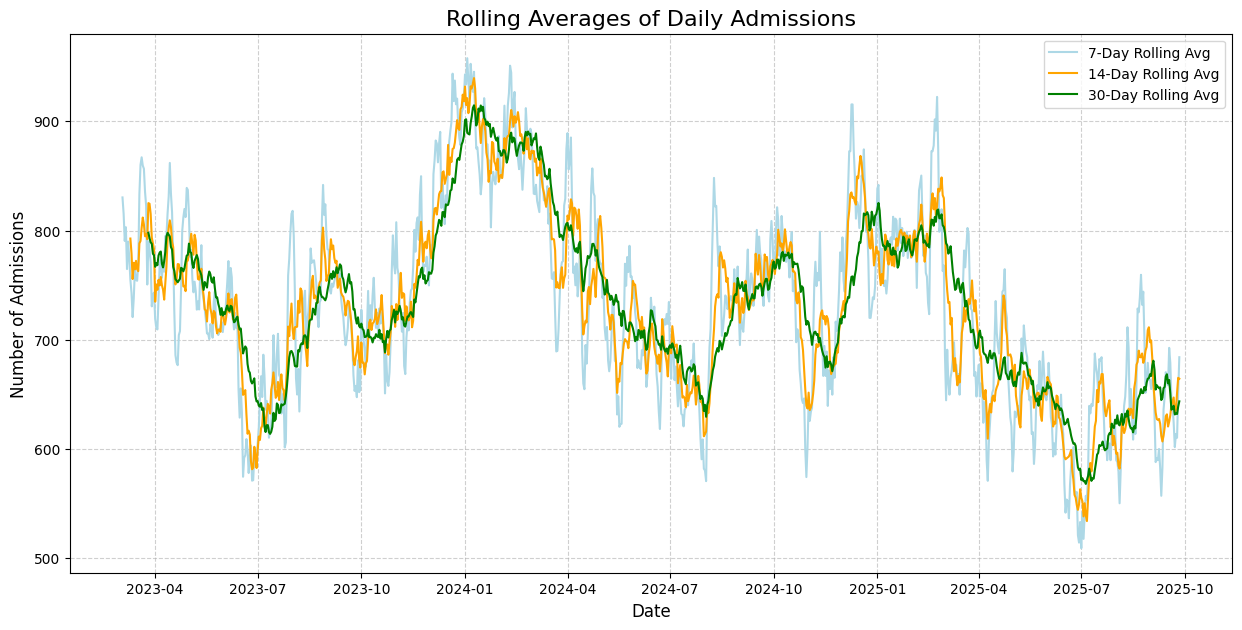

In [151]:
# Plot the rolling averages for the 7, 14 and 30 day periods
plt.figure(figsize=(15, 7))
plt.plot(daily_inflow['date'], daily_inflow['roll_7'], label='7-Day Rolling Avg', color='lightblue')
plt.plot(daily_inflow['date'], daily_inflow['roll_14'], label='14-Day Rolling Avg', color='orange')
plt.plot(daily_inflow['date'], daily_inflow['roll_30'], label='30-Day Rolling Avg', color='green')
plt.title('Rolling Averages of Daily Admissions', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Admissions', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The 7, 14 and 30 day rolling averages smooths (shape of the line) in a similar pattern.

The rolling averages displayed above shows a general trend. The 30 day rolling average is much smoother than the former two, because most of the noise associated have been dampened. 



## Step 3. Feature Engineering

We build our features for modelling and forecasting. 
To create a Lag by manipulating our daily inflow data into features for modelling and prediction purposes.

Create Forecasting TARGET variables

In [152]:
# Forecasting Target variables to predict future admissions / inflows
daily_inflow['target_7'] = daily_inflow['admissions'].shift(-7) # 7 day ahead target
daily_inflow['target_14'] = daily_inflow['admissions'].shift(-14) # 14 day ahead target
daily_inflow['target_30'] = daily_inflow['admissions'].shift(-30) # 30 day ahead target
daily_inflow.head()

,date,admissions,lag_1,lag_7,lag_14,lag_30,target_7,target_14,target_30,roll_7,roll_14,roll_30
0,2023-02-25,960,924,913,888,852,856,772,812,NaN,NaN,NaN
1,2023-02-26,848,960,924,1096,800,673,517,736,NaN,NaN,NaN
2,2023-02-27,612,848,960,876,1132,700,820,568,NaN,NaN,NaN
3,2023-02-28,948,612,948,656,828,680,865,676,NaN,NaN,NaN
4,2023-03-01,764,948,872,972,892,940,872,721,NaN,NaN,NaN


In [153]:
# Check for nulls in the dataframe after creating target features for the future.
daily_inflow.isnull().sum()

date           0
admissions     0
lag_1          0
lag_7          0
lag_14         0
lag_30         0
target_7       7
target_14     14
target_30     30
roll_7         6
roll_14       13
roll_30       29
dtype: int64

In [154]:
# Drop rows with NaN in target (columns =['target_7', 'target_14', 'target_30'])

daily_inflow = daily_inflow.dropna().reset_index(drop=True)



In [155]:
# Check to see what features have been created
print(daily_inflow['target_7'].head())
print(daily_inflow['target_14'].head())
print(daily_inflow['target_30'].head())
print(daily_inflow['roll_7'].head())
print(daily_inflow['roll_14'].head())
print(daily_inflow['roll_30'].head())

0    924
1    800
2    940
3    780
4    708
Name: target_7, dtype: Int64
0     852
1    1028
2     940
3     924
4     817
Name: target_14, dtype: Int64
0    960
1    736
2    824
3    752
4    836
Name: target_30, dtype: Int64
0    790.000000
1    782.000000
2    771.142857
3    730.571429
4    741.428571
Name: roll_7, dtype: float64
0    825.071429
1    824.500000
2    815.285714
3    793.571429
4    788.428571
Name: roll_14, dtype: float64
0    797.900000
1    792.966667
2    789.233333
3    787.766667
4    778.700000
Name: roll_30, dtype: float64


In [156]:
# Print the final daily_inflow DataFrame with lag features
daily_inflow.head(10)

,date,admissions,lag_1,lag_7,lag_14,lag_30,target_7,target_14,target_30,roll_7,roll_14,roll_30
0,2023-03-26,980,709,704,517,924,924,852,960,790.000000,825.071429,797.900000
1,2023-03-27,812,980,868,820,960,800,1028,736,782.000000,824.500000,792.966667
2,2023-03-28,736,812,812,865,848,940,940,824,771.142857,815.285714,789.233333
3,2023-03-29,568,736,852,872,612,780,924,752,730.571429,793.571429,787.766667
4,2023-03-30,676,568,600,748,948,708,817,836,741.428571,788.428571,778.700000
5,2023-03-31,721,676,709,800,764,604,820,744,743.142857,782.785714,777.266667
6,2023-04-01,541,721,709,1212,856,652,456,848,719.142857,734.857143,766.766667
7,2023-04-02,924,541,980,704,824,852,732,692,711.142857,750.571429,770.100000
8,2023-04-03,800,924,812,868,856,1028,736,780,709.428571,745.714286,768.233333
9,2023-04-04,940,800,736,812,673,940,592,640,738.571429,754.857143,777.133333


We now have our **Features (X)** as: *lag_1, lag_7, lag_14, lag_30 ,target_7, target_14, target_30, roll_7, roll_14, roll_30 columns* while our **Target (y)** are the *target_7, target_14, target_30* variables.

Lets check to see if these new  features created by Lag correlate with our target feature.

#### Correlation Matrix

In [157]:
# Correlation Matrix ( Auto corelation since we are taking the correlation between the same variable at different time lags )

daily_inflow.drop('date', axis=1).corr()



,admissions,lag_1,lag_7,lag_14,lag_30,target_7,target_14,target_30,roll_7,roll_14,roll_30
admissions,1.000000,0.284846,0.256474,0.236824,0.177867,0.258961,0.249930,0.173533,0.580977,0.526764,0.484257
lag_1,0.284846,1.000000,0.253353,0.199730,0.197934,0.233145,0.200224,0.185228,0.587959,0.537577,0.489140
lag_7,0.256474,0.253353,1.000000,0.257497,0.209118,0.246433,0.176244,0.193626,0.398429,0.536774,0.498117
lag_14,0.236824,0.199730,0.257497,1.000000,0.214330,0.173677,0.209894,0.133844,0.373002,0.424801,0.506386
lag_30,0.177867,0.197934,0.209118,0.214330,1.000000,0.185548,0.138455,0.092196,0.329147,0.374828,0.426271
target_7,0.258961,0.233145,0.246433,0.173677,0.185548,1.000000,0.258410,0.225547,0.381350,0.413073,0.407349
target_14,0.249930,0.200224,0.176244,0.209894,0.138455,0.258410,1.000000,0.210832,0.369291,0.390223,0.381204
target_30,0.173533,0.185228,0.193626,0.133844,0.092196,0.225547,0.210832,1.000000,0.300609,0.315972,0.296787
roll_7,0.580977,0.587959,0.398429,0.373002,0.329147,0.381350,0.369291,0.300609,1.000000,0.910271,0.834495
roll_14,0.526764,0.537577,0.536774,0.424801,0.374828,0.413073,0.390223,0.315972,0.910271,1.000000,0.928711


The values above tells us that:
- Admissions today are moderately correlated with admissions in the recent past.

- Positive correlation exists between the variables

- The correlation drops the further back you go.

- The values show normal behaviour for real-world time-series data (whuch are not too noisy, and are not perfectly seasonal)

It will make sense sif we can view this visually.


#### Auto correlation Matrix

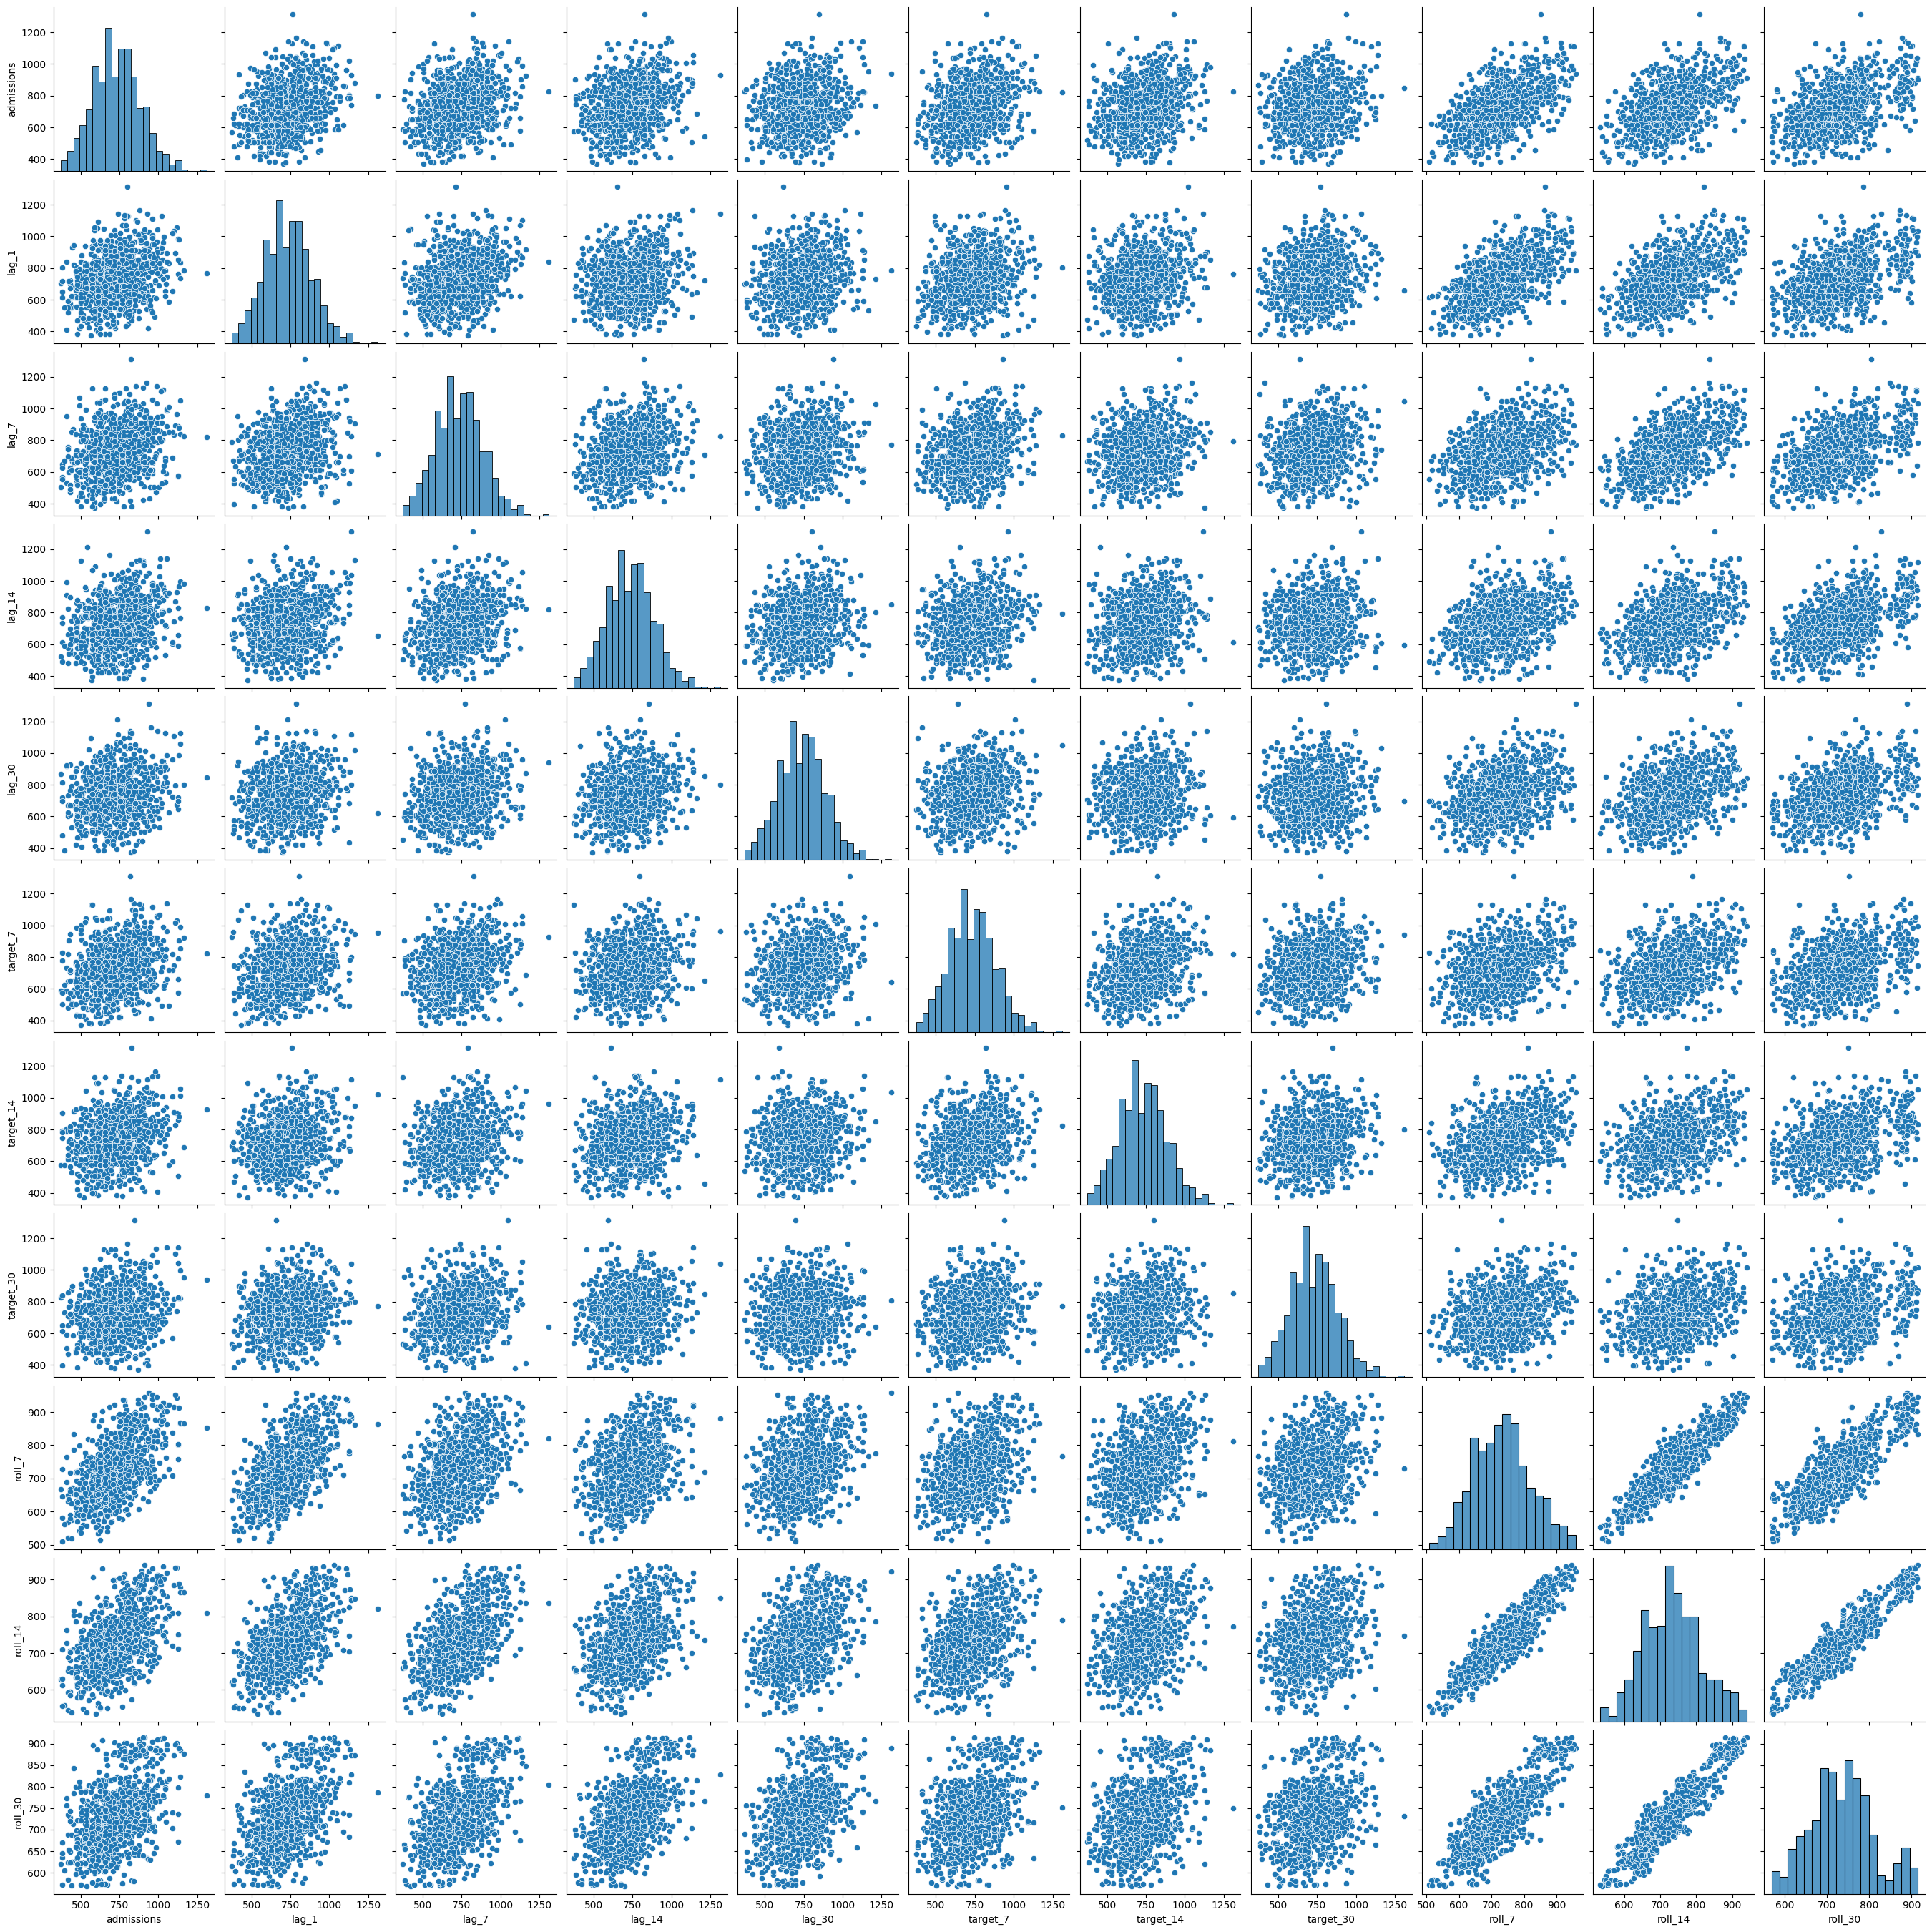

In [158]:
# Scatter plot matrix to visualize correlations
# admission Vs lag_7
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.scatter(x=daily_inflow["admissions"], y=daily_inflow["lag_7"])
# ax.plot([0,1300],[0,1300], linestyle= '--', color= "orange") # 45 degree line to indicate some symmetry (indicating the existence of some predictive power)
# plt.xlabel("admissions")
# plt.ylabel("lag_7")
# plt.title("7 day Inflow Autocorrelation");

sns.pairplot(daily_inflow.drop('date', axis=1))


### Split Data 

We will attempt to split our data into the train test split components to use for model development.

In [159]:
# Specify Features and Target variable

# X variables (features)

features = [
    'lag_1', 'lag_7', 'lag_14', 'lag_30',
    'roll_7', 'roll_14', 'roll_30'
]

X = daily_inflow[features]


# y variables for different forecasting horizons

y_7 = daily_inflow['target_7']
y_14 = daily_inflow['target_14']
y_30 = daily_inflow['target_30']

#### Train Test Split the data

In [160]:
# Split the data into train and test sets (80% train, 20% test)
split = int(len(X) * 0.8)

# 

X_train, X_test = X.iloc[:split], X.iloc[split:]
y7_train, y7_test = y_7.iloc[:split], y_7.iloc[split:]
y14_train, y14_test = y_14.iloc[:split], y_14.iloc[split:]
y30_train, y30_test = y_30.iloc[:split], y_30.iloc[split:]

## Step 4. Modelling
 - Baseline
 - Iterate
 - Evaluate